In [33]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder
import pickle


In [3]:

#/home/murat/Documents/python/kütüphaneler/opencvDeepLearning/6.evrimsel sinir aglar/rakam_sınıflandırma/myData
#6.evrimsel sinir aglar/rakam_sınıflandırma/myData
path = "/home/murat/Downloads/source/fruit/fruits-360-original-size/fruits-360-original-size/"
myList = os.listdir(path)
noOfClasses = len(myList)

In [4]:
myList

['Validation', 'Training', 'Test']

In [5]:
images=[]
classNo=[]
for i in myList:#
    filename=path+"/"+i # Training
    for j in os.listdir(filename): # under of training 
        j=j.lower()
        underfile=filename+"/"+j
        for k in os.listdir(underfile):
            img=cv2.imread(underfile+"/"+k)
            img = cv2.resize(img, (150,150))
            images.append(img)
            classNo.append(j.split("_")[0])




In [6]:
len(images),len(classNo)

(12455, 12455)

In [7]:
images = np.array(images)
classNo = np.array(classNo)

print(images.shape)
print(classNo.shape)

(12455, 150, 150, 3)
(12455,)


In [29]:
noOfClasses=len(set(classNo))

In [8]:
import pandas as pd
classNo_series=pd.Series(classNo)

In [9]:
classNo_series.value_counts()

apple       9641
pear         937
zucchini     640
cucumber     525
eggplant     320
carrot       201
cabbage      191
Name: count, dtype: int64

In [18]:
# veriyi ayırma
x_train, x_test, y_train, y_test = train_test_split(images, classNo, test_size=0.2, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("shape of images ",images.shape)
print("shape of x_train ",x_train.shape)
print("shape of x_test ",x_test.shape)
print("shape of x_validation ",x_validation.shape)


shape of images  (12455, 150, 150, 3)
shape of x_train  (7971, 150, 150, 3)
shape of x_test  (2491, 150, 150, 3)
shape of x_validation  (1993, 150, 150, 3)


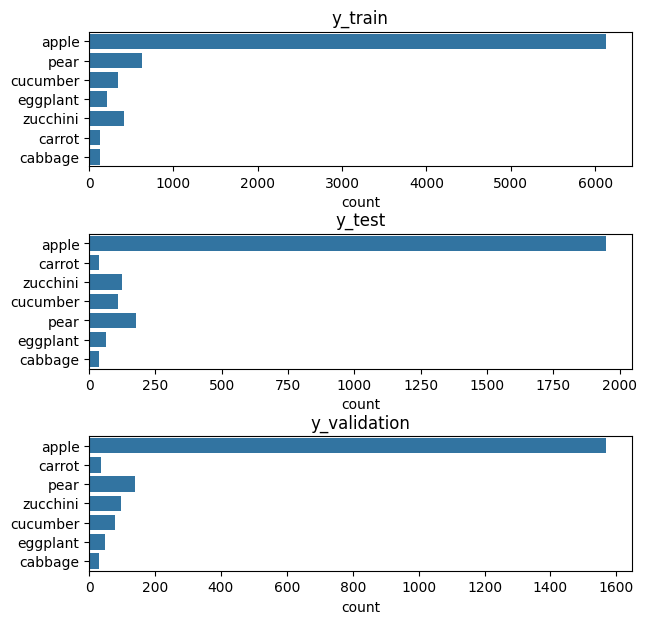

In [11]:
# # vis burası  comment olabilir 
fig, axes = plt.subplots(3,1,figsize=(7,7))
fig.subplots_adjust(hspace = 0.5)
sns.countplot(y_train, ax = axes[0])
axes[0].set_title("y_train")

sns.countplot(y_test, ax = axes[1])
axes[1].set_title("y_test")

sns.countplot(y_validation, ax = axes[2])
axes[2].set_title("y_validation")
plt.show()

In [12]:
def preProcess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255
    return img

In [13]:
# idx = 311
# img = preProcess(x_train[idx])
# img = cv2.resize(img,(300,300))
# cv2.imshow("Preprocess ",img)

In [19]:

x_train = np.array(list(map(preProcess, x_train)))
x_test = np.array(list(map(preProcess, x_test)))
x_validation = np.array(list(map(preProcess, x_validation)))


In [20]:
x_train = x_train.reshape(-1, 150,150, 1)
print(x_train.shape)
x_test = x_test.reshape(-1, 150,150, 1)
x_validation = x_validation.reshape(-1, 150,150, 1)


(7971, 150, 150, 1)


In [35]:

y_train = y_train.reshape(-1,1)
print(y_train.shape)
y_test = y_test.reshape(-1,1)
y_validation = y_validation.reshape(-1,1)


(7971, 1)


In [26]:
y_train.shape,x_train.shape,noOfClasses

((7971,), (7971, 150, 150, 1), 3)

In [31]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             rotation_range=10)

dataGen.fit(x_train)


In [36]:
encoder=OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test )
y_validation = encoder.fit_transform(y_validation)

In [37]:
model = Sequential()
model.add(Conv2D(input_shape=(150,150, 1), filters=8, kernel_size=(5, 5), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=noOfClasses, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=("Adam"), metrics=["accuracy"])

batch_size = 250

hist = model.fit_generator(dataGen.flow(x_train, y_train, batch_size=batch_size),
                           validation_data=(x_validation, y_validation),
                           epochs=35, steps_per_epoch=x_train.shape[0] // batch_size, shuffle=1)

Epoch 1/35
31/31 [==============================] - 17s 504ms/step - loss: 1.0248 - accuracy: 0.7538 - val_loss: 0.4931 - val_accuracy: 0.8299
Epoch 2/35
31/31 [==============================] - 15s 487ms/step - loss: 0.4874 - accuracy: 0.8399 - val_loss: 0.2352 - val_accuracy: 0.9237
Epoch 3/35
31/31 [==============================] - 15s 483ms/step - loss: 0.3207 - accuracy: 0.8895 - val_loss: 0.1768 - val_accuracy: 0.9548
Epoch 4/35
31/31 [==============================] - 15s 488ms/step - loss: 0.2426 - accuracy: 0.9176 - val_loss: 0.1015 - val_accuracy: 0.9764
Epoch 5/35
31/31 [==============================] - 15s 488ms/step - loss: 0.2025 - accuracy: 0.9310 - val_loss: 0.1505 - val_accuracy: 0.9488
Epoch 6/35
31/31 [==============================] - 15s 486ms/step - loss: 0.1749 - accuracy: 0.9396 - val_loss: 0.1411 - val_accuracy: 0.9403
Epoch 7/35
31/31 [==============================] - 15s 488ms/step - loss: 0.1487 - accuracy: 0.9497 - val_loss: 0.0806 - val_accuracy: 0.9764

In [38]:
pickle_out = open("model_fruit.p", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

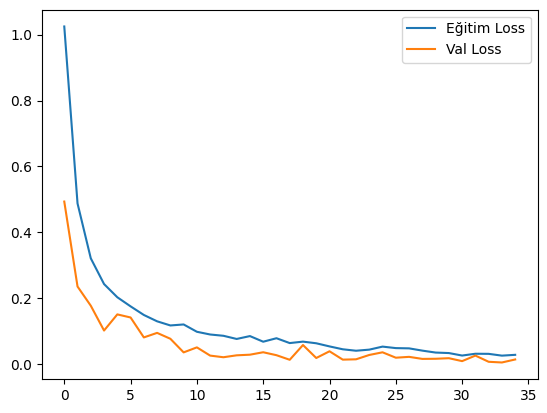

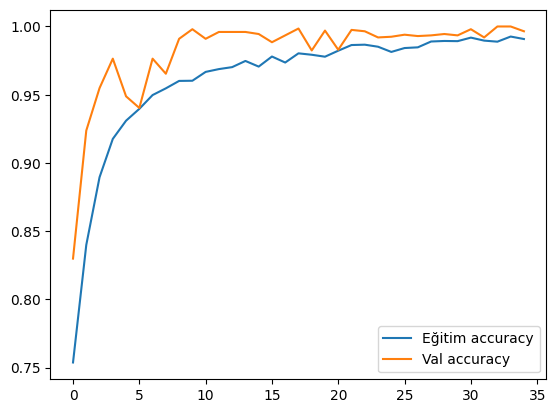

78/78 [==============================] - 1s 14ms/step - loss: 0.0159 - accuracy: 0.9952
Test loss:  0.015910638496279716
Test accuracy:  0.9951826333999634
63/63 [==============================] - 1s 13ms/step


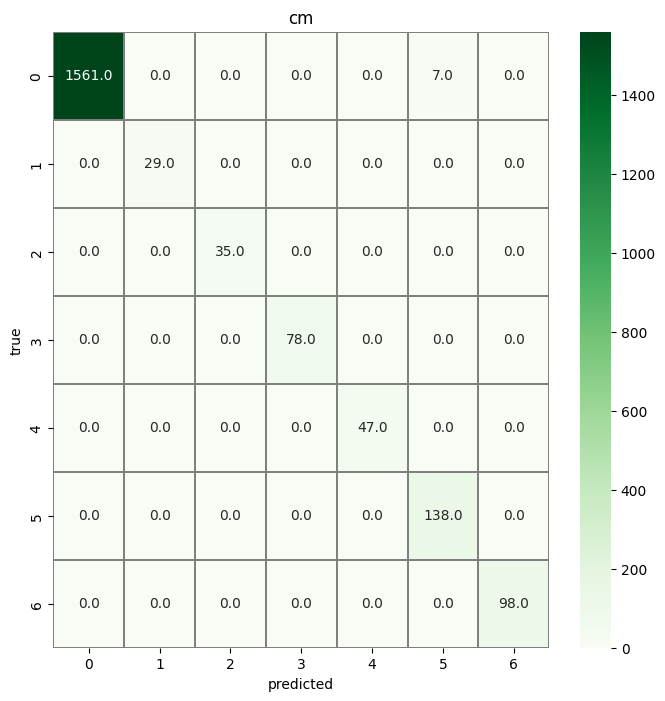

In [39]:
# %% degerlendirme
hist.history.keys()

plt.figure()
plt.plot(hist.history["loss"], label="Eğitim Loss")
plt.plot(hist.history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(hist.history["accuracy"], label="Eğitim accuracy")
plt.plot(hist.history["val_accuracy"], label="Val accuracy")
plt.legend()
plt.show()

score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

y_pred = model.predict(x_validation)
y_pred_class = np.argmax(y_pred, axis=1)
Y_true = np.argmax(y_validation, axis=1)
cm = confusion_matrix(Y_true, y_pred_class)
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt=".1f", ax=ax)
plt.xlabel("predicted")
plt.ylabel("true")
plt.title("cm")
plt.show()